In [33]:
import sys
sys.path.append('../')
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC
from joblib import Parallel, delayed
from AA_Fast import AA_Fast
import ast

In [34]:
def load_datasets_from_folder(folder_path):
    """Load all CSV datasets from a folder into a dictionary."""
    datasets = {}
    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            try:
                datasets[os.path.splitext(file)[0]] = pd.read_csv(os.path.join(folder_path, file))
            except Exception as e:
                print(f"Warning: Failed to load {file} - {e}")
    return datasets

folder_path = r"\\wsl.localhost\Ubuntu\home\kleinr1\RF-Overample\datasets"
datasets = load_datasets_from_folder(folder_path)

print(f"Total datasets loaded successfully: {len(datasets)}")
print("Successfully loaded datasets:")
for name, df in datasets.items():
    print(f" - {name} (Rows: {len(df)}, Columns: {len(df.columns)})")

Total datasets loaded successfully: 30
Successfully loaded datasets:
 - tic-tac-toe (Rows: 958, Columns: 10)
 - heart_disease (Rows: 303, Columns: 14)
 - lymphography (Rows: 148, Columns: 19)
 - sonar (Rows: 208, Columns: 61)
 - flare1 (Rows: 323, Columns: 11)
 - crx (Rows: 664, Columns: 15)
 - hepatitis (Rows: 138, Columns: 16)
 - mnist_test (Rows: 10000, Columns: 785)
 - wine (Rows: 178, Columns: 14)
 - balance_scale (Rows: 625, Columns: 5)
 - seeds (Rows: 199, Columns: 8)
 - optdigits (Rows: 3823, Columns: 65)
 - glass (Rows: 214, Columns: 10)
 - breast_cancer (Rows: 699, Columns: 10)
 - artificial_tree (Rows: 5000, Columns: 41)
 - chess (Rows: 3196, Columns: 37)
 - ecoli_5 (Rows: 327, Columns: 8)
 - audiology (Rows: 190, Columns: 68)
 - titanic (Rows: 712, Columns: 8)
 - iris (Rows: 150, Columns: 5)
 - ionosphere (Rows: 351, Columns: 35)
 - parkinsons (Rows: 195, Columns: 23)
 - zoo (Rows: 101, Columns: 18)
 - hill_valley (Rows: 606, Columns: 101)
 - segmentation (Rows: 211, Column

In [35]:
class DatasetPreprocessor:
    def __init__(self, dataset, target_column=None, test_size=0.2, random_state=42, encoding_method='ordinal', native_resampler=False):
        """
        Initializes the DatasetPreprocessor.

        Args:
            dataset (pd.DataFrame): The dataset to preprocess.
            target_column (str, optional): The name of the target column. Defaults to the first column.
            test_size (float): Proportion of the dataset to allocate for testing.
            random_state (int): Random seed for reproducibility.
            encoding_method (str): Encoding method for categorical variables. Options: 'ordinal' or 'onehot'.
            native_resampler (bool): If True, forces ordinal encoding to support native resamplers (e.g., SMOTENC, ADASYN)
                                     that require categorical features as integer codes.
        """
        self.dataset = dataset.copy()
        self.target_column = target_column if target_column else dataset.columns[0]
        self.test_size = test_size
        self.random_state = random_state
        self.encoding_method = 'ordinal' if native_resampler else encoding_method.lower()
        self.native_resampler = native_resampler
        self.x_train, self.x_test, self.y_train, self.y_test = None, None, None, None
        self.cat_cols = []
        self._prepare_data()

    def _prepare_data(self):
        # Separate features (X) and target (y)
        x = self.dataset.drop(columns=[self.target_column])
        y = self.dataset[self.target_column]

        # Identify categorical columns and store them
        cat_cols = x.select_dtypes(include=["object", "category"]).columns
        self.cat_cols = list(cat_cols)

        if len(cat_cols) > 0:
            if self.encoding_method == "ordinal":
                # Convert each categorical column to integer codes
                x[cat_cols] = x[cat_cols].apply(lambda col: col.astype("category").cat.codes)
                print(f"Ordinal encoded categorical columns: {self.cat_cols}")
            elif self.encoding_method == "onehot":
                # Create dummy variables for each categorical column
                x = pd.get_dummies(x, columns=cat_cols, drop_first=True)
                print(f"One-hot encoded categorical columns: {self.cat_cols}")
            else:
                raise ValueError(f"Unknown encoding method: {self.encoding_method}. Choose 'ordinal' or 'onehot'.")

        # Perform train-test split (encoding is done before splitting since all categories are well represented)
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
            x, y, test_size=self.test_size, random_state=self.random_state
        )

        print("\nData Preparation Complete")
        print(f"Train-Test Split: Train ({len(self.x_train)}) | Test ({len(self.x_test)})")
        print(f"Feature Columns: {len(x.columns)} | Categorical Processed: {len(self.cat_cols)}\n")

In [36]:
class ImbalanceHandler:
    def __init__(self, x_train, y_train, imbalance_ratio=0.2, batch_size=20, random_state=42):
        """
        Initializes the ImbalanceHandler class.

        Args:
            x_train (pd.DataFrame): Training feature set.
            y_train (pd.Series): Training labels.
            imbalance_ratio (float): Target imbalance ratio (default 0.2 for 20% minority).
            batch_size (int): The number of total samples per batch (default 20).
            random_state (int): Random seed for reproducibility.
        """
        self.x_train = x_train
        self.y_train = y_train
        self.imbalance_ratio = imbalance_ratio
        self.batch_size = batch_size
        self.random_state = random_state

    def apply_resampling(self, df, n_samples):
        n_samples = max(1, min(n_samples, len(df)))
        return resample(df, replace=False, n_samples=n_samples, random_state=self.random_state)

    def introduce_imbalance(self):
        print(f"\nApplying imbalance ratio: {self.imbalance_ratio:.2f}")

        # Combine features & labels
        train_df = pd.concat([self.x_train, self.y_train.to_frame()], axis=1)

        # Get class distributions
        class_counts = self.y_train.value_counts()
        print(f"\nOriginal Class Distribution:\n{class_counts.to_string()}")

        # Identify majority and minority class
        minority_class = class_counts.idxmin()
        majority_class = class_counts.idxmax()

        # Separate the classes
        minority_samples = train_df[train_df[self.y_train.name] == minority_class]
        majority_samples = train_df[train_df[self.y_train.name] == majority_class]

        # Adjust class sizes safely
        def adjust_class_size(df):
            adjusted_size = (len(df) // self.batch_size) * self.batch_size
            return self.apply_resampling(df, adjusted_size)

        minority_samples = adjust_class_size(minority_samples)
        majority_samples = adjust_class_size(majority_samples)

        print(f"\nAdjusted Sizes - Minority: {len(minority_samples)}, Majority: {len(majority_samples)}")

        # Apply Imbalance Ratio
        minority_per_batch = max(1, int(self.batch_size * self.imbalance_ratio))
        majority_per_batch = max(1, self.batch_size - minority_per_batch)

        # Ensure we have enough samples to run at least one iteration
        max_iterations = min(
            len(minority_samples) // minority_per_batch,
            len(majority_samples) // majority_per_batch
        )

        if max_iterations == 0:
            print("[WARNING] Not enough samples to introduce the desired imbalance ratio. Returning original dataset.")
            return self.x_train, self.y_train

        final_samples = [
            pd.concat([
                self.apply_resampling(minority_samples, minority_per_batch),
                self.apply_resampling(majority_samples, majority_per_batch)
            ])
            for _ in range(max_iterations)
        ]

        imbalanced_train_df = pd.concat(final_samples).sample(frac=1, random_state=self.random_state).reset_index(drop=True)

        print(f"\nNew Class Distribution:\n{imbalanced_train_df[self.y_train.name].value_counts().to_string()}")

        return imbalanced_train_df.drop(columns=[self.y_train.name]), imbalanced_train_df[self.y_train.name]

In [37]:
class ResamplingHandler:
    def __init__(self, x_train, y_train, random_state=42):
        self.x_train = x_train
        self.y_train = y_train
        self.random_state = random_state

    def apply_smote(self):
        """Applies SMOTE and returns the resampled dataset."""
        smote = SMOTE(random_state=self.random_state)
        x_resampled, y_resampled = smote.fit_resample(self.x_train, self.y_train)
        return x_resampled, y_resampled

    def apply_adasyn(self):
        """Applies ADASYN with a lower number of neighbors and returns the resampled dataset."""
        adasyn = ADASYN(random_state=self.random_state, n_neighbors=30)
        x_resampled, y_resampled = adasyn.fit_resample(self.x_train, self.y_train)
        return x_resampled, y_resampled

    
    def apply_smotenc(self, categorical_features):
        """Applies SMOTENC and returns the resampled dataset."""
        smotenc = SMOTENC(categorical_features=categorical_features, random_state=self.random_state)
        x_resampled, y_resampled = smotenc.fit_resample(self.x_train, self.y_train)
        return x_resampled, y_resampled

In [38]:
def run_archetypal_analysis(X, y, n_archetypes=10):
    """
    Runs Archetypal Analysis separately for majority and minority classes.

    Args:
        X (pd.DataFrame): Feature dataset.
        y (pd.Series): Target labels.
        n_archetypes (int): Number of archetypes to extract.

    Returns:
        pd.DataFrame: Archetypal points for the minority class.
    """
    minority_class = y.value_counts().idxmin()
    majority_class = y.value_counts().idxmax()

    # Separate majority and minority class samples
    X_minority = X[y == minority_class]
    X_majority = X[y == majority_class]

    # Convert to numpy arrays
    X_minority_array = X_minority.to_numpy()

    # Run Archetypal Analysis on minority class only
    aa_minority = AA_Fast(n_archetypes=min(n_archetypes, len(X_minority_array)))
    aa_minority.fit(X_minority_array)

    # Extract archetypes (focus only on the minority class for oversampling)
    archetypes_minority = pd.DataFrame(aa_minority.Z, columns=X_minority.columns)

    return archetypes_minority, X_majority

In [39]:
class ModelTrainer:
    def __init__(self, x_train, y_train, x_test, y_test, random_state=42):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.random_state = random_state
        self.model = None
        self.imbalanced_x_train = x_train.copy()
        self.imbalanced_y_train = y_train.copy()

    def reset_training_data(self):
        self.x_train = self.imbalanced_x_train.copy()
        self.y_train = self.imbalanced_y_train.copy()

    def train_and_evaluate(self, method="none", max_depth=2):
        self.reset_training_data()
        print(f"\n[INFO] Training with method: {method.upper()}")
        print("Class distribution before training:\n", self.y_train.value_counts(normalize=True))

        if method == "class_weights":
            model = RandomForestClassifier(max_depth=max_depth, class_weight="balanced", random_state=self.random_state)
        else:
            model = RandomForestClassifier(max_depth=max_depth, random_state=self.random_state)

        model.fit(self.x_train, self.y_train)
        self.model = model

        predictions = model.predict(self.x_test)

        # Ensure class presence in report
        labels = sorted(list(set(self.y_test.unique()) | set(predictions)))
        report_dict = classification_report(self.y_test, predictions, output_dict=True, labels=labels, zero_division=0)
        report_df = pd.DataFrame(report_dict).T

        if "accuracy" not in report_df.index:
            report_df.loc["accuracy"] = [report_dict["accuracy"], None, None, None]

        print("\n[INFO] Model Evaluation Complete")
        return report_df


In [40]:
class ExperimentRunner:
    """Runs multiple dataset configurations with different imbalance techniques and models."""

    def __init__(self, target_column=None, n_jobs=-1, categorical_features=None):
        """
        Args:
            target_column (str, optional): The target column to be used. 
                                           If None, defaults to the first column of each dataset.
            n_jobs (int): Number of parallel jobs to run.
            categorical_features (list, optional): For SMOTENC, the indices of categorical features.
        """
        self.target_column = target_column
        self.n_jobs = n_jobs
        self.categorical_features = categorical_features

    def run_multiple_configs(self, datasets, methods, imbalance_ratios):
        """
        Runs experiments with different datasets, methods, and imbalance ratios in parallel.
        Args:
            datasets (dict): Dictionary of dataset names mapped to their DataFrame.
            methods (list): List of imbalance handling methods.
            imbalance_ratios (list): List of imbalance ratios to test.
        Returns:
            pd.DataFrame: A DataFrame containing experiment results.
        """
        results = Parallel(n_jobs=self.n_jobs)(
            delayed(self._run_single_config)(name, dataset, method, ratio)
            for name, dataset in datasets.items()
            for method in methods
            for ratio in imbalance_ratios
        )
        return pd.DataFrame(results)

    def _run_single_config(self, dataset_name, dataset, method, imbalance_ratio):
        """
        Runs a single configuration of dataset preprocessing, imbalance handling,
        resampling, and model training.
        """
        try:
            # Use the explicitly provided target column, or default to the first column
            target_column = self.target_column or dataset.columns[0]

            # Step 1: Preprocess dataset
            preprocessor = DatasetPreprocessor(dataset, target_column=target_column)
            x_train, x_test, y_train, y_test = (
                preprocessor.x_train,
                preprocessor.x_test,
                preprocessor.y_train,
                preprocessor.y_test,
            )

            # Step 2: Apply ImbalanceHandler to adjust the imbalance ratio
            imbalance_handler = ImbalanceHandler(x_train, y_train, imbalance_ratio)
            x_train, y_train = imbalance_handler.introduce_imbalance()

            # Step 3: Apply resampling if required
            if method in ["smote", "adasyn", "smotenc", "archetypal_smote"]:
                resampler = ResamplingHandler(x_train, y_train)

                if method == "smote":
                    x_train, y_train = resampler.apply_smote()
                elif method == "adasyn":
                    x_train, y_train = resampler.apply_adasyn()
                elif method == "smotenc":
                    if self.categorical_features is None:
                        auto_cat_cols = list(x_train.select_dtypes(include=["object", "category"]).columns)
                        categorical_features = [x_train.columns.get_loc(col) for col in auto_cat_cols]
                        print("Auto-detected categorical feature indices for SMOTENC:", categorical_features)
                        if not categorical_features:
                            raise ValueError("No categorical features detected for SMOTENC.")
                    else:
                        categorical_features = self.categorical_features
                    x_train, y_train = resampler.apply_smotenc(categorical_features)
                elif method == "archetypal_smote":
                    archetypes_minority, _ = run_archetypal_analysis(x_train, y_train)
                    minority_class = y_train.value_counts().idxmin()
                    archetypes_labels = pd.Series([minority_class] * len(archetypes_minority), name=y_train.name)
                    x_train = pd.concat([x_train, archetypes_minority], ignore_index=True)
                    y_train = pd.concat([y_train, archetypes_labels], ignore_index=True)

            # Step 4: Train model & evaluate
            trainer = ModelTrainer(x_train, y_train, x_test, y_test)
            result = trainer.train_and_evaluate(method=method)

            return {
                "dataset": dataset_name,
                "method": method,
                "imbalance_ratio": imbalance_ratio,
                "classification_report": result.to_dict() if hasattr(result, "to_dict") else result,
            }

        except Exception as e:
            return {
                "dataset": dataset_name,
                "method": method,
                "imbalance_ratio": imbalance_ratio,
                "error": str(e),
            }


In [95]:
datasets

{'tic-tac-toe':           win TL TM TR ML MM MR BL BM BR
 0    positive  x  x  x  x  o  o  x  o  o
 1    positive  x  x  x  x  o  o  o  x  o
 2    positive  x  x  x  x  o  o  o  o  x
 3    positive  x  x  x  x  o  o  o  b  b
 4    positive  x  x  x  x  o  o  b  o  b
 ..        ... .. .. .. .. .. .. .. .. ..
 953  negative  o  x  x  x  o  o  o  x  x
 954  negative  o  x  o  x  x  o  x  o  x
 955  negative  o  x  o  x  o  x  x  o  x
 956  negative  o  x  o  o  x  x  x  o  x
 957  negative  o  o  x  x  x  o  o  x  x
 
 [958 rows x 10 columns],
 'heart_disease':      class  age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  \
 0        0   63    1   1       145   233    1        2      150      0   
 1        2   67    1   4       160   286    0        2      108      1   
 2        1   67    1   4       120   229    0        2      129      1   
 3        0   37    1   3       130   250    0        0      187      0   
 4        0   41    0   2       130   204    0        2      

In [112]:
datasets1 = {"diabetes": datasets["diabetes"]}
methods = ["none", "class_weights", "smote", "smotenc", "archetypal_smote"]
imbalance_ratios = [0.05, 0.1, 0.15, 0.2]
# "adasyn"

runner = ExperimentRunner(categorical_features=[1, 6])
results_df = runner.run_multiple_configs(datasets1, methods, imbalance_ratios)

In [ ]:
# datasets2 = {"crx": datasets["crx"]}

In [113]:
results_df

,dataset,method,imbalance_ratio,classification_report
0,diabetes,none,0.05,"{'precision': {'0': 0.6470588235294118, '1': 1..."
1,diabetes,none,0.10,"{'precision': {'0': 0.6712328767123288, '1': 0..."
2,diabetes,none,0.15,"{'precision': {'0': 0.6762589928057554, '1': 0..."
3,diabetes,none,0.20,"{'precision': {'0': 0.7297297297297297, '1': 0..."
4,diabetes,class_weights,0.05,"{'precision': {'0': 0.6447368421052632, '1': 0..."
5,diabetes,class_weights,0.10,"{'precision': {'0': 0.6879432624113475, '1': 0..."
6,diabetes,class_weights,0.15,"{'precision': {'0': 0.6690647482014388, '1': 0..."
7,diabetes,class_weights,0.20,"{'precision': {'0': 0.75, '1': 0.58, 'accuracy..."
8,diabetes,smote,0.05,"{'precision': {'0': 0.6447368421052632, '1': 0..."
9,diabetes,smote,0.10,"{'precision': {'0': 0.6830985915492958, '1': 0..."


In [114]:
results_df.to_csv("experiment_results.csv", index=False)

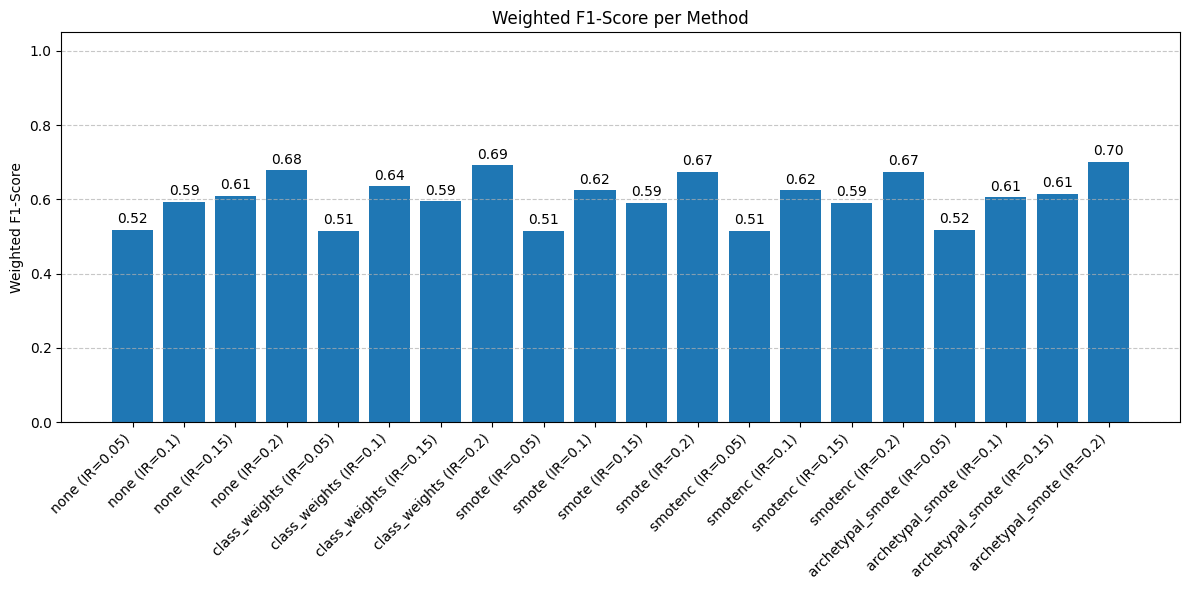

In [115]:
df = pd.read_csv("experiment_results.csv")
df["classification_report"] = df["classification_report"].apply(ast.literal_eval)

df["weighted_f1"] = df["classification_report"].apply(
    lambda report: report.get("f1-score", {}).get("weighted avg", None) if isinstance(report, dict) else None
)

df["label"] = df.apply(
    lambda row: f"{str(row['method'])} (IR={str(row['imbalance_ratio'])})", axis=1
)

filtered_df = df.dropna(subset=["weighted_f1"])

plt.figure(figsize=(12, 6))
bars = plt.bar(filtered_df["label"], filtered_df["weighted_f1"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Weighted F1-Score")
plt.title("Weighted F1-Score per Method")
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{height:.2f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()